# Conformal Object Detection: first steps

This tutorial should get you started doing **Conformal Object Detection (COD)** with the [`cods`](https://github.com/leoandeol/cods) library.

For more information on the methods implemented in CODS, see the papers: 
- [Andéol et al. 2023: Confident Object Detection via Conformal Prediction and Conformal Risk Control](https://proceedings.mlr.press/v204/andeol23a.html)
- [Angelopoulos et al. 2022: Conformal Risk Control](https://arxiv.org/abs/2208.02814)
- [Li et al. 2022: Towards PAC Multi-Object Detection and Tracking](https://arxiv.org/abs/2204.07482)
- [Bates et al. 2021: Risk Controlling Prediction Sets](https://dl.acm.org/doi/abs/10.1145/3478535)


### Get started
1. Download the MS-COCO dataset: 
    - https://cocodataset.org/
2. Download DETR: automatically via Pytorch hub: https://pytorch.org/hub/
    - source: https://github.com/facebookresearch/detr

### Contents
What we will be doing:
1. Setup inference [⤵](#Setup-inferences)
    - load predictor (DETR) pretrained on COCO
    - Split the validation into: calibration & validation dataset
2. Run inferences on these datasets [⤵](#Setup-inferences)
    - Save predictions to disk: faster than re-predict for every test
3. Test Conformal Prediction !

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import logging
import os

from cods.od.data import MSCOCODataset
from cods.od.models import DETRModel

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = (
    "1"  # chose the GPU. If only one, then "0"
)

logging.getLogger().setLevel(logging.DEBUG)

## 2. Setup inferences [🔝](#conformal-object-detection-first-steps)

In [3]:
# set [COCO_PATH] to the directory to your local copy of the COCO dataset
COCO_PATH = "/datasets/shared_datasets/coco/"

data = MSCOCODataset(root=COCO_PATH, split="val")

In [4]:
calibration_ratio = (
    0.5  # set 0.5 to use 50% for calibration and 50% for testing
)

use_smaller_subset = True  # TODO: Temp

if use_smaller_subset:
    data_cal, data_val = data.split_dataset(
        calibration_ratio, shuffle=False, n_calib_test=800
    )
else:
    data_cal, data_val = data.split_dataset(calibration_ratio, shuffle=False)

# model and weights are downloaded from https://github.com/facebookresearch/detr
model = DETRModel(model_name="detr_resnet50", pretrained=True, device="cpu")
# model = YOLOModel(model_name="yolov8x.pt", pretrained=True)


print(f"{len(data) = }")
print(f"{len(data_cal) = }")
print(f"{len(data_val) = }")

Using cache found in /home/leo.andeol/.cache/torch/hub/facebookresearch_detr_main
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


len(data) = 5000
len(data_cal) = 400
len(data_val) = 400


Run inferences:
- the first time, run inferences and save them disk
- if predictions are saved on disk, load them

In [5]:
preds_cal = model.build_predictions(
    data_cal,
    dataset_name="mscoco",
    split_name="cal",
    batch_size=12,
    collate_fn=data._collate_fn,  # TODO: make this a default for COCO
    shuffle=False,
    force_recompute=False,  # False,
    deletion_method="nms",
)
preds_val = model.build_predictions(
    data_val,
    dataset_name="mscoco",
    split_name="test",
    batch_size=12,
    collate_fn=data._collate_fn,
    shuffle=False,
    force_recompute=False,  # False,
    deletion_method="nms",
)

Predictions already exist, loading them...
Predictions already exist, loading them...


# New Tests

In [6]:
from cods.od.cp import ODConformalizer

# TODO: debug lac
conf = ODConformalizer(
    guarantee_level="image",
    matching_function="mix",  # "giou",
    multiple_testing_correction=None,
    confidence_method="box_count_recall",  # "nb_boxes",
    # confidence_threshold=0.5,
    localization_method="pixelwise",  # "pixelwise",
    localization_prediction_set="multiplicative",  # "multiplicative",
    classification_method="binary",
    classification_prediction_set="lac",
    backend="auto",
    optimizer="binary_search",
)

[2025-06-09 00:47:23:WARNING:cp.py:cp:1499 - __init__ ] No multiple_testing_correction provided, assuming no correction is needed. The explicit list of alphas is expected for calibration.
[2025-06-09 00:47:23:INFO:cp.py:cp:197 - __init__ ] Defaulting to CRC backend
[2025-06-09 00:47:23:INFO:cp.py:cp:1037 - __init__ ] Defaulting to CRC backend


In [7]:
# TODO(leo): we can replace this by anything, doesn't even need a guarantee (confidence)
parameters = conf.calibrate(
    preds_cal,
    alpha_confidence=0.02,
    alpha_localization=0.05,
    alpha_classification=0.05,
)


[2025-06-09 00:47:23:INFO:cp.py:cp:1739 - calibrate ] Calibrating Confidence Conformalizer
[2025-06-09 00:47:23:DEBUG:cp.py:cp:828 - calibrate ] Optimizing for lambda_plus
  0%|          | 0/400 [00:00<?, ?it/s]/home/leo.andeol/envs/cods_13/cods/cods/od/utils.py:495: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  Qst = torch.FloatTensor([Qs]).to(device)
100%|██████████| 400/400 [00:00<00:00, 1350.66it/s]
[2025-06-09 00:47:24:DEBUG:optim.py:optim:214 - optimize ] Risk after 1st epoch is 0.0024937656708061695 < 0.02


First risk: 0.0024937656708061695


λ=0.9973763823509216. Corrected Risk = 0.0062:  23%|██▎       | 3566/15831 [00:05<00:26, 469.66it/s]

λ=0.9258965253829956. Corrected Risk = 0.0203:  56%|█████▌    | 8798/15831 [00:15<00:12, 569.22it/s]
[2025-06-09 00:47:39:DEBUG:cp.py:cp:842 - calibrate ] Optimizing for lambda_minus


--------------------------------------------------
Lambdas
	previous_lbd = 0.9259868860244751
	Last Lambda = 0.9258965253829956
	Other previous lbd = 0.9259868860244751
	Other current lbd = 0.9258965253829956
All risks raw (precomputed):
	Confidence Risk: 0.019421683624386787
	Localization Risk: 0.0024937656708061695
	Classification Risk: 0.0024937656708061695
	Max Risk: 0.019421683624386787
All risks monotonized (precomputed):
	Confidence Risk: 0.019421683624386787
	Localization Risk: 0.0024937656708061695
	Classification Risk: 0.0024937656708061695
	Max Risk: 0.019421683624386787
Confidence risk (recomputed):
	Confidence Risk: 0.016970239579677582
Comparison of the two :
	 (isclose) 0.9975000023841858
	 (eq) 0.9975000023841858
	Image 241 loss: tensor([0.]) (eval) vs tensor([0.3333]) (opti)
	Image 241 confidence: tensor([9.9930e-01, 9.7942e-01, 7.4013e-02, 2.7801e-03, 5.3779e-04, 1.4966e-04, 4.0226e-05, 3.5833e-05])
	Image 241 number of ground truths: 3
	Image 241 number of prediction

100%|██████████| 400/400 [00:00<00:00, 1288.99it/s]
[2025-06-09 00:47:40:DEBUG:optim.py:optim:214 - optimize ] Risk after 1st epoch is 0.0 < 0.02


First risk: 0.0


λ=0.8939547538757324. Corrected Risk = 0.0203:  60%|█████▉    | 9437/15831 [00:17<00:11, 549.00it/s]
[2025-06-09 00:47:57:INFO:cp.py:cp:1749 - calibrate ] Setting Confidence Threshold of Predictions
[2025-06-09 00:47:57:INFO:cp.py:cp:1760 - calibrate ] Calibrated Confidence λ : 0.9260
	 and associated Confidence Threshold : 0.0740131139755249
[2025-06-09 00:47:57:INFO:cp.py:cp:1775 - calibrate ] Matching Predictions to True Boxes


--------------------------------------------------
Lambdas
	previous_lbd = 0.8939756751060486
	Last Lambda = 0.8939547538757324
	Other previous lbd = 0.8939756751060486
	Other current lbd = 0.8939547538757324
All risks raw (precomputed):
	Confidence Risk: 0.019837310537695885
	Localization Risk: 0.0
	Classification Risk: 0.0
	Max Risk: 0.019837310537695885
All risks monotonized (precomputed):
	Confidence Risk: 0.019837310537695885
	Localization Risk: 0.0
	Classification Risk: 0.0
	Max Risk: 0.019837310537695885
Confidence risk (recomputed):
	Confidence Risk: 0.01988690346479416
Comparison of the two :
	 (isclose) 0.9975000023841858
	 (eq) 0.9975000023841858
	Image 321 loss: tensor([0.4000]) (eval) vs tensor([0.6000]) (opti)
	Image 321 confidence: tensor([9.9710e-01, 9.6895e-01, 1.0602e-01, 1.2346e-02, 9.4007e-03, 7.1957e-03, 5.5087e-03, 1.9307e-03, 1.6665e-03, 1.6233e-03, 1.5269e-03, 1.4993e-03, 1.1777e-03, 9.1440e-04, 7.0673e-04, 7.0442e-04, 4.9990e-04, 4.5839e-04, 3.9857e-04, 3.7900e

400it [00:00, 9276.87it/s]
[2025-06-09 00:47:57:INFO:cp.py:cp:1788 - calibrate ] Calibrating Localization Conformalizer
[2025-06-09 00:47:57:INFO:cp.py:cp:469 - calibrate ] Using overload confidence threshold: 0.1060
[0.29, 0.32] -> λ=0.30517578125. Corrected Risk = 0.05: 100%|██████████| 13/13 [00:56<00:00,  4.36s/it]
[2025-06-09 00:48:54:INFO:cp.py:cp:526 - calibrate ] Calibrated λ for localization: 0.30517578125
[2025-06-09 00:48:54:INFO:cp.py:cp:1798 - calibrate ] Calibrated Localization λ : 0.30517578125
[2025-06-09 00:48:54:INFO:cp.py:cp:1806 - calibrate ] Calibrating Classification Conformalizer
[2025-06-09 00:48:54:INFO:cp.py:cp:1170 - calibrate ] Using overload confidence threshold: 0.1060
[2025-06-09 00:48:54:WARNING:cp.py:cp:1175 - calibrate ] Currently considering that there is only one matching prediction to each true box for classification pruposes. To add later how to aggregate if multiple preidctions matched.
[1.00, 1.00] -> λ=0.9999988377094269. Corrected Risk = 0.05: 

In [11]:
conf.confidence_conformalizer.lambda_minus, conf.confidence_conformalizer.lambda_plus

(np.float32(0.8939757), np.float32(0.9259869))

In [12]:
conf.confidence_conformalizer.lambda_minus, conf.confidence_conformalizer.lambda_plus

(np.float32(0.8939757), np.float32(0.9259869))

[2025-06-09 00:50:52:DEBUG:pyplot.py:pyplot:497 - switch_backend ] Loaded backend module://matplotlib_inline.backend_inline version unknown.
[2025-06-09 00:50:52:DEBUG:pyplot.py:pyplot:497 - switch_backend ] Loaded backend module://matplotlib_inline.backend_inline version unknown.
[2025-06-09 00:50:52:DEBUG:font_manager.py:font_manager:1471 - _findfont_cached ] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
[2025-06-09 00:50:52:DEBUG:font_manager.py:font_manager:1483 - _findfont_cached ] findfont: score(FontEntry(fname='/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2025-06-09 00:50:52:DEBUG:font_manager.py:font_manager:1483 - _findfont_cached ] findfont: score(FontEntry(fname='/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/matpl

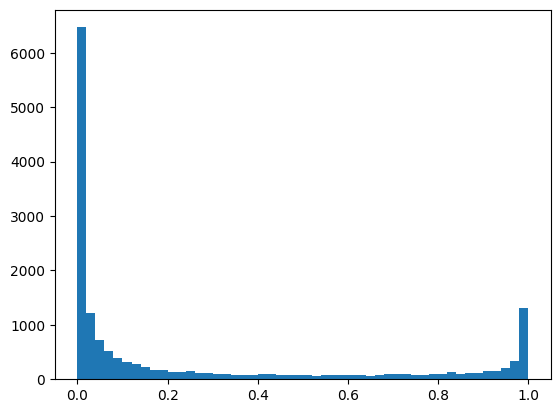

In [8]:
import torch
import numpy as np

scores = torch.concatenate(preds_cal.confidences)
import matplotlib.pyplot as plt

plt.hist(scores.detach().cpu().numpy(), bins=50);

In [9]:
sorted_scores, _ = torch.sort(scores)
sorted_scores = sorted_scores.detach().cpu().numpy()
sorted_scores = np.concatenate((sorted_scores, [1]))

plt.plot(
    sorted_scores,
    list(reversed(conf.confidence_conformalizer.optimizer2.all_risks_raw)),
    label="Raw",
)
plt.plot(
    sorted_scores,
    list(reversed(conf.confidence_conformalizer.optimizer2.all_risks_mon)),
    label="Monotonized",
)
plt.title(f"Raw vs Monotonized loss, parameterized by lambda")
plt.legend();

AttributeError: 'ConfidenceConformalizer' object has no attribute 'optimizer2'

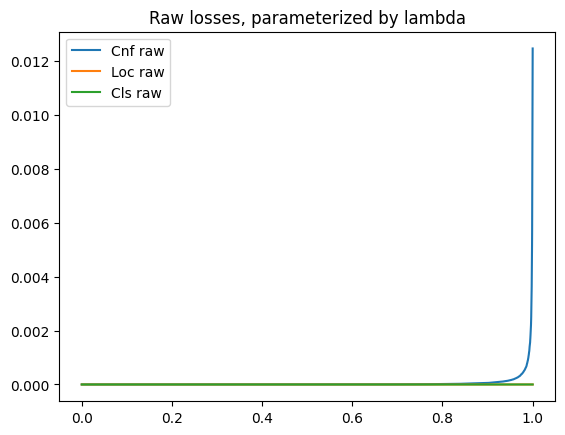

In [ ]:
sorted_scores, _ = torch.sort(scores)
sorted_scores = sorted_scores.detach().cpu().numpy()
sorted_scores = np.concatenate((sorted_scores, [1]))

plt.plot(
    sorted_scores,
    list(
        reversed(conf.confidence_conformalizer.optimizer2.all_risks_raw_conf)
    ),
    label="Cnf raw",
)
plt.plot(
    sorted_scores,
    list(reversed(conf.confidence_conformalizer.optimizer2.all_risks_raw_loc)),
    label="Loc raw",
)
plt.plot(
    sorted_scores,
    list(reversed(conf.confidence_conformalizer.optimizer2.all_risks_raw_cls)),
    label="Cls raw",
)
plt.title(f"Raw losses, parameterized by lambda")
plt.legend();

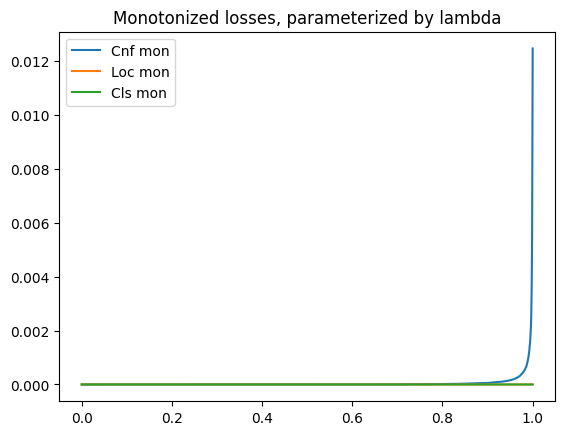

In [ ]:
sorted_scores, _ = torch.sort(scores)
sorted_scores = sorted_scores.detach().cpu().numpy()
sorted_scores = np.concatenate((sorted_scores, [1]))

plt.plot(
    sorted_scores,
    list(
        reversed(conf.confidence_conformalizer.optimizer2.all_risks_mon_conf)
    ),
    label="Cnf mon",
)
plt.plot(
    sorted_scores,
    list(reversed(conf.confidence_conformalizer.optimizer2.all_risks_mon_loc)),
    label="Loc mon",
)
plt.plot(
    sorted_scores,
    list(reversed(conf.confidence_conformalizer.optimizer2.all_risks_mon_cls)),
    label="Cls mon",
)
plt.title(f"Monotonized losses, parameterized by lambda")
plt.legend();

In [ ]:
conformal_preds = conf.conformalize(preds_val, parameters=parameters)

[INFO:cp.py:cp:1622 - conformalize ] Conformalizing Predictions
[INFO:cp.py:cp:1625 - conformalize ] Using provided parameters for conformalization
[INFO:cp.py:cp:1631 - conformalize ] The parameters have been computed on another set of predictions.
[INFO:cp.py:cp:1650 - conformalize ] Using provided confidence threshold
[INFO:cp.py:cp:1659 - conformalize ] Conformalizing Localization
[INFO:cp.py:cp:513 - conformalize ] Using previous λ for localization
[INFO:cp.py:cp:528 - conformalize ] Conformalizing Localization with λ
[INFO:cp.py:cp:1669 - conformalize ] Conformalizing Classification


In [ ]:
# TODO: Rewrite it so we only compute the confidence loss and not the max of three. Main loss of condiecne shoudl be just itself but in calibration use the proxy maximum loss with the others
results_val = conf.evaluate(
    preds_val,
    parameters=parameters,
    conformalized_predictions=conformal_preds,
    include_confidence_in_global=False,
)

[INFO:cp.py:cp:1722 - evaluate ] Evaluating Localization Conformalizer
[INFO:cp.py:cp:1735 - evaluate ] Evaluating Classification Conformalizer
[WARNING:loss.py:loss:338 - __call__ ] true_cls is empty : tensor([], dtype=torch.int64)
[WARNING:loss.py:loss:338 - __call__ ] true_cls is empty : tensor([], dtype=torch.int64)
[WARNING:loss.py:loss:338 - __call__ ] true_cls is empty : tensor([], dtype=torch.int64)
100%|██████████| 400/400 [00:02<00:00, 152.18it/s]
[INFO:cp.py:cp:1765 - evaluate ] Evaluation Results:
[INFO:cp.py:cp:1773 - evaluate ] 	 Localization:
[INFO:cp.py:cp:1774 - evaluate ] 		 Risk: 0.03
[INFO:cp.py:cp:1775 - evaluate ] 		 Mean Set Size: 2.95
[INFO:cp.py:cp:1779 - evaluate ] 	 Classification:
[INFO:cp.py:cp:1780 - evaluate ] 		 Risk: 0.07
[INFO:cp.py:cp:1781 - evaluate ] 		 Mean Set Size: 11.00
[INFO:cp.py:cp:1785 - evaluate ] 	 Global:
[INFO:cp.py:cp:1786 - evaluate ] 		 Risk: 0.09


[INFO:cp.py:cp:1711 - evaluate ] Evaluating Localization Conformalizer
[INFO:cp.py:cp:1724 - evaluate ] Evaluating Classification Conformalizer
[WARNING:loss.py:loss:337 - __call__ ] true_cls is empty : tensor([], dtype=torch.int64)
[WARNING:loss.py:loss:337 - __call__ ] true_cls is empty : tensor([], dtype=torch.int64)
[WARNING:loss.py:loss:337 - __call__ ] true_cls is empty : tensor([], dtype=torch.int64)
100%|██████████| 400/400 [00:01<00:00, 260.52it/s]
[INFO:cp.py:cp:1754 - evaluate ] Evaluation Results:
[INFO:cp.py:cp:1762 - evaluate ] 	 Localization:
[INFO:cp.py:cp:1763 - evaluate ] 		 Risk: 0.06
[INFO:cp.py:cp:1764 - evaluate ] 		 Mean Set Size: 2.22
[INFO:cp.py:cp:1768 - evaluate ] 	 Classification:
[INFO:cp.py:cp:1769 - evaluate ] 		 Risk: 0.05
[INFO:cp.py:cp:1770 - evaluate ] 		 Mean Set Size: 23.53
[INFO:cp.py:cp:1774 - evaluate ] 	 Global:
[INFO:cp.py:cp:1775 - evaluate ] 		 Risk: 0.08

Using confidence threshold from preds


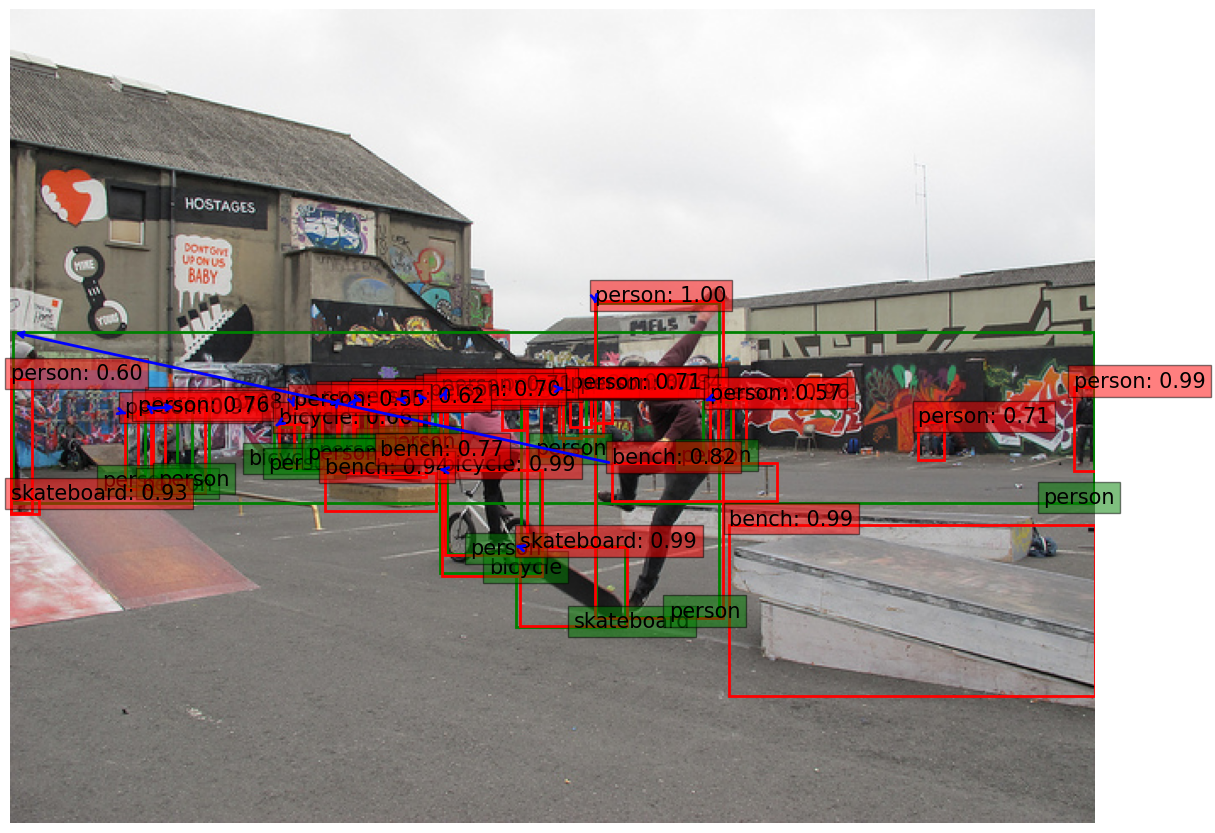

Number of ground truths: 17
Number of predictions: 80
Number of filtered prediction: 34


In [ ]:
from cods.od.visualization import plot_preds

# Plot ground truths and predictions for the image with index 0
idx = 3
plot_preds(idx, preds_cal, None, idx_to_label=MSCOCODataset.NAMES)
print("Number of ground truths:", len(preds_cal.true_cls[idx]))
print("Number of predictions:", len(preds_cal.confidence[idx]))
print(
    "Number of filtered prediction:",
    sum(preds_cal.confidence[idx] > preds_cal.confidence_threshold).item(),
)

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torch


def my_plot_preds(
    idx,
    predictions,
    conformalized_predictions=None,
    confidence_threshold=None,
    idx_to_label: dict = None,
    save_as=None,
):
    """
    Plot the predictions of an object detection model.

    Args:
        preds (object): Object containing the predictions.
        idx (int): Index of the image to plot.
        conf_boxes (list): List of confidence boxes.
        conf_cls (list): List of confidence classes.
        confidence_threshold (float, optional): Confidence threshold for filtering predictions. If not provided, the threshold from `preds` will be used. Defaults to None.
        save_as (str, optional): File path to save the plot. Defaults to None.
    """
    is_conformal = conformalized_predictions is not None

    img_path = predictions.image_paths[idx]
    pred_boxes = predictions.pred_boxes[idx]
    true_boxes = predictions.true_boxes[idx]
    true_cls = predictions.true_cls[idx]
    conf = predictions.confidence[idx]
    cls_probas = predictions.pred_cls[idx]

    if is_conformal:
        conf_boxes = conformalized_predictions.conf_boxes[idx]
        conf_cls = conformalized_predictions.conf_cls[idx]

    if (
        confidence_threshold is None
        and predictions.confidence_threshold is not None
    ):
        confidence_threshold = predictions.confidence_threshold
        print("Using confidence threshold from preds")
    else:
        raise ValueError("Confidence Threshold should be provided")

    keep = conf > confidence_threshold
    pred_boxes = pred_boxes[keep]
    if is_conformal:
        conf_boxes = conf_boxes[keep]
    cls_probas = cls_probas[keep]

    image = Image.open(img_path)
    image_width, image_height = image.size
    image.save("./test.png")

    def draw_rect(ax, box, color, proba, conformal=False):
        """
        Draw a rectangle on the plot.

        Args:
            ax (object): Axes object of the plot.
            box (list): List of coordinates [x1, y1, x2, y2] of the rectangle.
            color (str): Color of the rectangle.
            proba (int or numpy.ndarray): Probability or probability distribution of the class.
        """
        x1, y1, x2, y2 = box
        # correct coordinates to not go outside of bounds
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(image_width, x2)
        y2 = min(image_height, y2)

        ax.add_patch(
            plt.Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                fill=False,
                edgecolor=color,
                linewidth=2,
            )
        )
        # TODO(leo):conf
        if conformal:
            if len(proba) <= 3:
                # Print up to the three labels of the prediction sets
                if idx_to_label is not None:
                    text = ", ".join([f"{idx_to_label[cl]}" for cl in proba])
                else:
                    text = ", ".join([f"{cl}" for cl in proba])
                ax.text(
                    x1,
                    y1,
                    text,
                    fontsize=15,
                    bbox=dict(facecolor=color, alpha=0.5),
                )
            else:
                # Print nb of labels
                text = f"{len(proba)} labels"
                ax.text(
                    x1,
                    y1,
                    text,
                    fontsize=15,
                    bbox=dict(facecolor=color, alpha=0.5),
                )
        else:
            if isinstance(proba, int) or len(proba.shape) == 0:
                if isinstance(proba, torch.Tensor):
                    proba = proba.item()
                if idx_to_label is not None:
                    text = f"{idx_to_label[proba]}" if proba >= 0 else "conf"
                else:
                    text = f"{proba}" if proba >= 0 else "conf"
                ax.text(
                    x2 - 30,
                    y2,
                    text,
                    fontsize=15,
                    bbox=dict(facecolor=color, alpha=0.5),
                )
            else:
                cl = proba.argmax().item()
                if idx_to_label is not None:
                    text = f"{idx_to_label[cl]}: {proba[cl]:0.2f}"
                else:
                    text = f"{cl}: {proba[cl]:0.2f}"

                ax.text(
                    x1,
                    y1,
                    text,
                    fontsize=15,
                    bbox=dict(facecolor=color, alpha=0.5),
                )

    for i, (box, cl) in enumerate(zip(true_boxes, true_cls)):
        plt.figure(figsize=(14, 14))
        plt.imshow(image)
        ax = plt.gca()
        draw_rect(ax, box, "green", cl)

        matching_pred_box = pred_boxes[predictions.matching[idx][i][0]]
        matching_prob = cls_probas[predictions.matching[idx][i][0]]
        prob = matching_prob

        box = matching_pred_box.detach().cpu().numpy()
        draw_rect(ax, box, "red", prob)
        plt.show()

    # if is_conformal:
    #     for box, conf_cls_i in zip(conf_boxes, conf_cls):
    #         box = box.detach().cpu().numpy()
    #         draw_rect(ax, box, "purple", conf_cls_i, conformal=True)


Using confidence threshold from preds


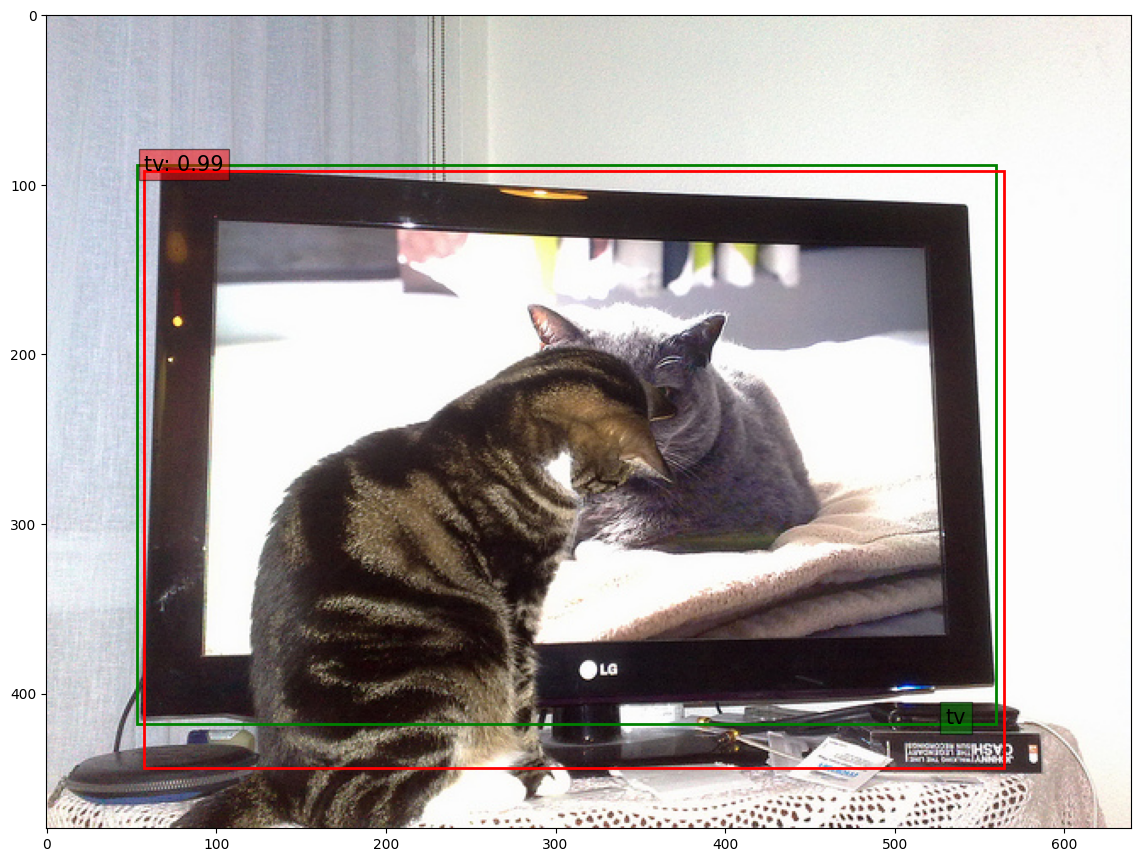

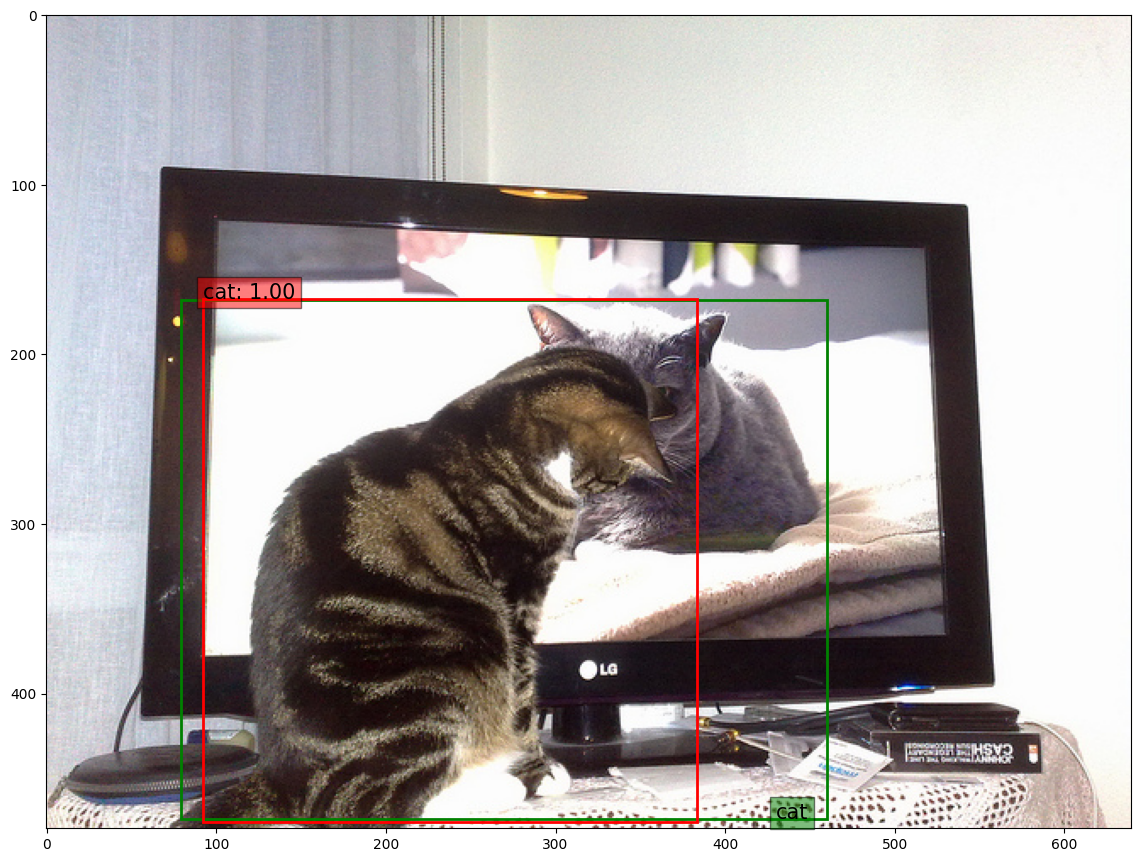

In [ ]:
idx = 18
my_plot_preds(
    idx, preds_val, conformal_preds, idx_to_label=MSCOCODataset.NAMES
)


Using confidence threshold from preds


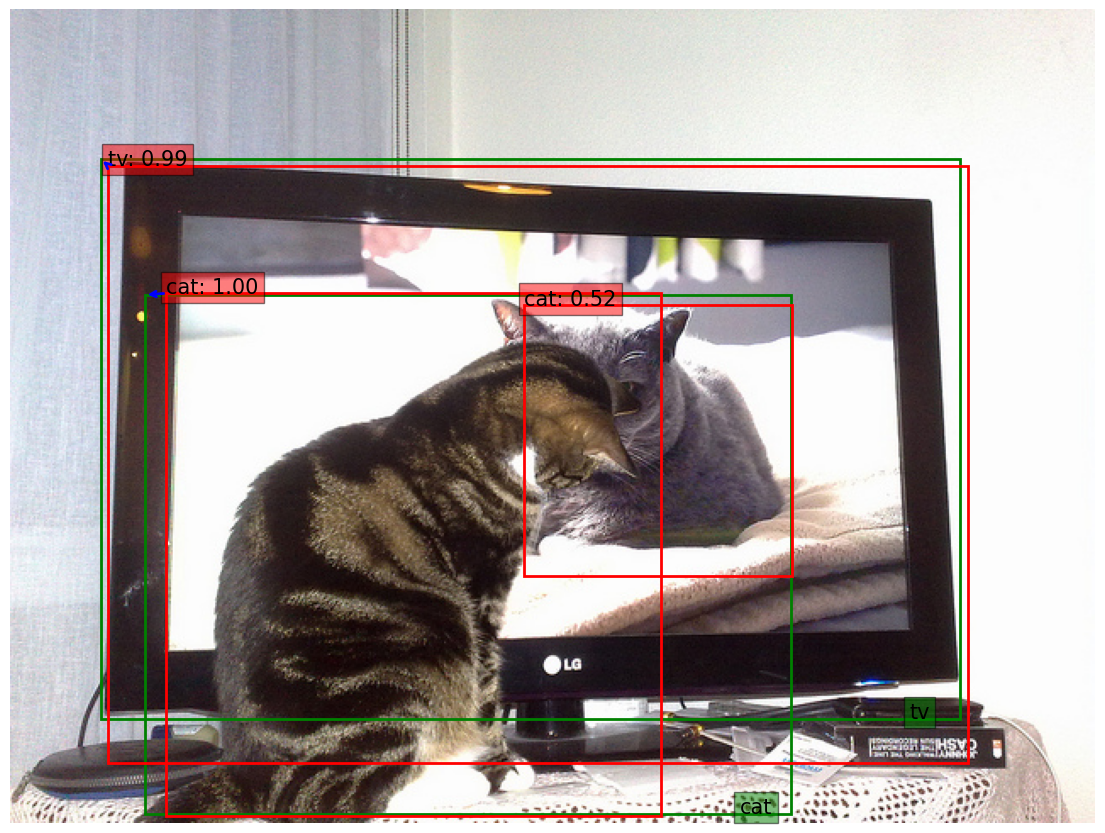

In [ ]:
from cods.od.visualization import plot_preds

plot_preds(idx, preds_val, None, idx_to_label=MSCOCODataset.NAMES)


Using confidence threshold from preds


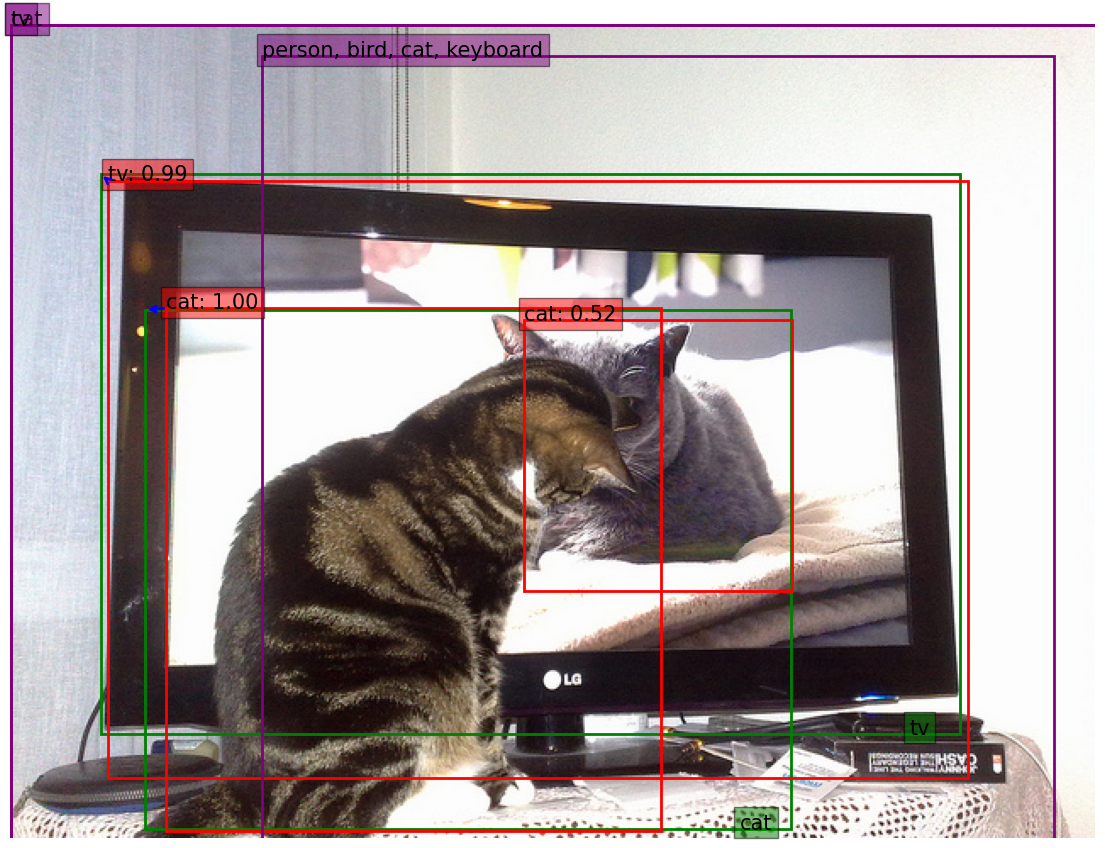

In [ ]:
from cods.od.visualization import plot_preds

plot_preds(idx, preds_val, conformal_preds, idx_to_label=MSCOCODataset.NAMES)


In [ ]:
pred_cls = preds_val.pred_cls[idx]
pred_conf = preds_val.confidence[idx]
true_cls = preds_val.true_cls[idx]
matching = preds_val.matching[idx]

pairs = [
    (x, preds_val.pred_cls[matching[i][0]].argmax())
    for i, x in enumerate(true_cls)
]
for x, y in pairs:
    print(f"{x=}, {y=}")

x=tensor(21), y=tensor(20)
x=tensor(21), y=tensor(10)
x=tensor(21), y=tensor(20)
x=tensor(21), y=tensor(32)
x=tensor(21), y=tensor(32)
x=tensor(21), y=tensor(1)
x=tensor(21), y=tensor(1)
x=tensor(21), y=tensor(1)
x=tensor(21), y=tensor(1)
x=tensor(21), y=tensor(1)


In [ ]:
print(matching)

[[1], [3], [0], [5], [5], [2], [4], [4], [4], [4]]


In [ ]:
from cods.od.metrics import unroll_metrics

unroll_metrics(preds_val, conformal_preds)

Defaulting to predictions' confidence threshold


TypeError: getAveragePrecision() got multiple values for argument 'verbose'